# RespiCoV sequencing analysis by primer

Analyze fastq file(s) from nanopore sequencing output using [RespiCoV](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264855) primers. Designed for ligation sequencting chemistry.

Run here on my first RespiCoV sequencing attempt where I knew (from gel) that I had a lot of mis-priming, and where my flow cell was nearly exhausted. 

**Goals:**
 * Identify likely target matches per input sample, for downstream sequence alignment
 * Quantify PCR effectiveness and visualize the ways in which PCR mis-priming occurs in practice.
 * Run quickly on a single machine and scale linearly with input sequence
 * Enable iterative exploration of the data (cache the most expensive operations)

**TODO:**
 * How useful are quality scores for identifying possible errors?
 * What's the distribution of read lengths for reads with no primer hits?
 * What do short spans tend to map to?
 * Generate histogram of how much of each read is occuppied by primer sequence
 
**Non-goals / future work elsewhere:**
 * Virus type-analysis for matches
 * Integrate Kraken / minimap2 analysis to suggest likely source of mis-priming. In particular, human matches
 * Map to human genome to study off-target mispriming in practice
 * Map reads to target genome sequences
 * Attempt to separate reads from distinct genomes pooled into the same barcode (eg. by type)
 * Use reads which only include one (or even zero) primers, eg. for tagmentation chemistry

## Initialization and configuration

In [1]:
from Bio.Seq import Seq
from Bio import SeqIO
import matplotlib_inline.backend_inline
import os
import gzip
import pandas as pd
import RCUtils

# Get high-dpi output for retina displays
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

fastQBaseDir = "../20221204_2344_MN41817_FAV39017_1bf37150/fastq_pass/"

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

primers = RCUtils.readPrimers("RespiCovPrimers.fasta")
print("Read %i primers" % (len(primers)))

# Store primer indicies for efficient serialization
for i, primer in enumerate(primers):
    primer.index = i
    primer.baseName = primer.description[:primer.description.rindex(' ')]

Read 115 primers


## Compute and save primer matches if needed
Includes all the functions for getting reads and hits

In [2]:
from IPython.display import clear_output 
from Bio import Align
import time
import json

def serializeHit(hit):
    return [hit.primer.index, hit.start, hit.end, hit.rev, hit.mr]

def deserializeHit(hitBuf):
    return RCUtils.Hit(primer=primers[hitBuf[0]], start=hitBuf[1], end=hitBuf[2], rev=hitBuf[3], mr=hitBuf[4])

def getFastQAndHitsFiles(subdir):
    fastQDir = os.path.join(fastQBaseDir, subdir)
    for file in sorted(filter(lambda f: f.endswith(".fastq.gz"), os.listdir(fastQDir))):
        fastQPath = os.path.join(fastQDir, file)
        yield (fastQPath, fastQPath.removesuffix(".fastq.gz")+"-hits.json")

# Get reads from a gzipped fastQ file
def readFastQ(path):
    with gzip.open(path, "rt") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            yield record

# Find primer matches and save them to files if files don't already exist
def generateHitsFile(subdir, overwrite=False):
    for (fastQPath, hitsPath) in getFastQAndHitsFiles(subdir):
        if overwrite or not os.path.exists(hitsPath):
            print("Processing ", os.path.basename(fastQPath), end="")
            reads = 0
            start = time.process_time()
            serializedHitsPerRead = []
            for read in readFastQ(fastQPath):
                reads += 1
                if reads % 100 == 0:
                    print(".",end="")
                hits = RCUtils.computePrimerHits(read, primers)
                serializedHitsPerRead.append([serializeHit(hit) for hit in hits])

            elapsed = time.process_time() - start
            print("  %.2fs" % elapsed)

            with open(hitsPath, "w") as f:
                json.dump(serializedHitsPerRead, f)
        else:
            print("Found ", os.path.basename(hitsPath))

def getAllFastQDirs():
    for dir in sorted(os.listdir(fastQBaseDir)):
        if dir.startswith("barcode"):
            yield dir

# Return all raw reads in a sub-directory on their own
def getReads(subdir):
    for (fastQPath,_) in getFastQAndHitsFiles(subdir):
        for read in readFastQ(fastQPath):
            yield read

def getAllReads():
    for subdir in getAllFastQDirs():
        for read in getReads(subdir):
            yield read

# Stream all reads for a given subdirectory, along with the pre-computed primer matches
def getPrimerMatches(subdir):
    for (fastQPath,hitsPath) in getFastQAndHitsFiles(subdir):
        with open(hitsPath, "r") as hitsFile:
            serializedHitsPerRead = json.load(hitsFile)
            
        for (readIdx,read) in enumerate(readFastQ(fastQPath)):
            hits = []
            for hitBuf in serializedHitsPerRead[readIdx]:
                hit = deserializeHit(hitBuf)
                assert hit.start < len(read.seq)
                assert hit.end <= len(read.seq)
                hits.append(hit)
            yield (read, hits)
                
def getAllPrimerMatches():
    for subdir in getAllFastQDirs():
        for (r,h) in getPrimerMatches(subdir):
            yield (subdir, r, h)

# Actually generate all the hits files
for subdir in getAllFastQDirs():
    generateHitsFile(subdir)

Processing  FAV39017_pass_barcode01_1d0a44b7_0.fastq.gz......  1.54s
Processing  FAV39017_pass_barcode02_1d0a44b7_0.fastq.gz......  1.54s
Processing  FAV39017_pass_barcode03_1d0a44b7_0.fastq.gz....  1.11s
Processing  FAV39017_pass_barcode04_1d0a44b7_0.fastq.gz......  1.56s
Processing  FAV39017_pass_barcode05_1d0a44b7_0.fastq.gz......  1.59s
Processing  FAV39017_pass_barcode06_1d0a44b7_0.fastq.gz.......  1.79s
Processing  FAV39017_pass_barcode07_1d0a44b7_0.fastq.gz........  1.91s
Processing  FAV39017_pass_barcode08_1d0a44b7_0.fastq.gz........  1.86s


## How many primers are found in each read?
Notable here is that, in my first experiment nearly every read included at least one primer, suggesting PCR products did dominate the results. 
Proper amplification and sequencing should typically result in 2 primers per read, which is indeed the most common result. But it's also very common to have only a single primer.
It's also not unusual to have several primers, suggesting primer-dimers.

In [38]:
from collections import Counter

readsPerPrimerCount = Counter()
readTotal = 0
for (subdir, read, hits) in getAllPrimerMatches():
    readTotal += 1
    readsPerPrimerCount[len(hits)] += 1

table = pd.DataFrame.from_dict(readsPerPrimerCount, orient="index", columns=["Reads"])
table.index.name = "Primer Count"
table.sort_index(inplace=True)
table["%"] = table["Reads"].apply(lambda r: round(r / readTotal, ndigits=4))
table

,Reads,%
Primer Count,,
0,214,3.9%
1,1296,23.3%
2,3246,58.4%
3,486,8.8%
4,253,4.5%
5,33,0.6%
6,18,0.3%
7,9,0.2%


## What is the distribution of primer match scores
Most hits exactly match a primer, but small numbers of mismatches are not uncommon.
In earlier testing, match scores of around 60% and lower were extremely common, purely by chance.

4372 of 10594 (41%) of primer hits are a perfect match


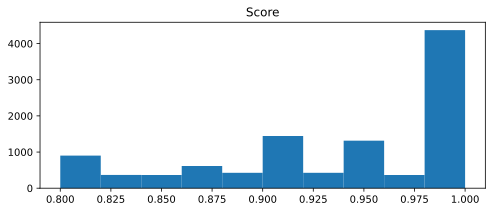

In [4]:
mrs = []
perfect = 0
for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        mrs.append(hit.mr)
        if hit.mr == 1.0:
            perfect += 1

print("%d of %d (%d%%) of primer hits are a perfect match" % (perfect, len(mrs), 100*perfect/len(mrs)))
pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=10, grid=False);

## How often is each primer seen?
With a highly-specific PCR reaction I would expect to see the primer matches dominated by the legitimate target sequences. That's not the case here, suggesting perhaps the annealing temp was too low. More analysis is clearly needed in order to identify likely targets in the data.

,Fwd hits,Rev hits,%,Avg MR
Primer,,,,
Influenza A virus 2,125,131,2.42,0.96
SARS coronavirus 1/2 3,130,115,2.31,0.94
Chlamydophila pneumoniae 2,128,117,2.31,0.95
Mycoplasma pneumoniae 1,139,101,2.27,0.95
Hendra virus 5,131,108,2.26,0.94
Hantaan virus 3,95,134,2.16,0.95
Streptococcus pneumoniae 2,110,104,2.02,0.95
Human parechovirus 1,86,109,1.84,0.96
Mycoplasma pneumoniae 2,98,94,1.81,0.92


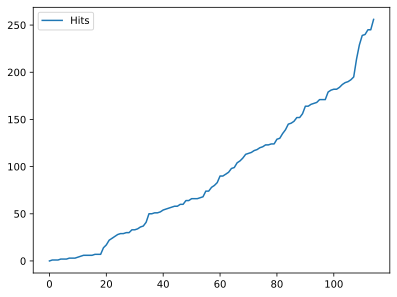

In [5]:
hitsPerPrimer = dict()
for p in primers:
    hitsPerPrimer[p.description] = [0,0,0]

hitsTotal = 0
for (subdir, record, hits) in getAllPrimerMatches():
    hitsTotal += len(hits)
    for hit in hits:
        hitsPerPrimer[hit.primer.description][1 if hit.rev else 0] += 1
        hitsPerPrimer[hit.primer.description][2] += hit.mr

def addPercent (entry):
    (primer, [fwd,rev,mrtot]) = entry
    return (primer, fwd, rev, round((fwd+rev) / hitsTotal * 100, ndigits=2), round(mrtot / (fwd+rev), ndigits=2))

allHits = sorted([f+r for (f, r, m) in hitsPerPrimer.values()])
pd.DataFrame(allHits, columns=["Hits"]).plot()

data = map(addPercent, filter(lambda p:p[1]!=[0,0,0], hitsPerPrimer.items()))
table = pd.DataFrame(data, columns=["Primer","Fwd hits", "Rev hits", "%", "Avg MR"])
table.set_index("Primer", inplace=True)
table.sort_values("%", ascending=False, inplace=True)
table

## Which primers are never seen exactly?
Given the high rate of off-target amplification in this experiment, if a primer is never seen at all, that may suggest a failure in the assay preparation
or synthesis. 

In [35]:
primerMaxMatch = dict.fromkeys(map(lambda p:p.description, primers), (0,0.0))

for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        (count, maxMr) = primerMaxMatch[hit.primer.description]
        primerMaxMatch[hit.primer.description] = (count+1, max(maxMr, hit.mr))

table = pd.DataFrame.from_dict(primerMaxMatch, orient="index", columns=["Hits", "Max Match"])
table.index.name = "Primer"
table.sort_values("Max Match", ascending=False, inplace=True)
table[table["Max Match"] < 1.0]

,Hits,Max Match
Primer,,
Influenza A virus 22,7,96.0%
Influenza A virus 20,3,96.0%
Influenza B virus 5,2,87.0%
Random control,1,82.0%
Human respiratory syncytial virus 1.0,3,81.0%
Human respiratory syncytial virus 1.1,0,0.0%


There's only one hit of the random control primer and it has a score of 82%, suggesting our threshold of 80% is pretty good. 

There's only 3 hits of the RSV 1 primer and they're all about 81% suggesting they could all be false positives. I had some issues resuspending primers, so perhaps this one didn't actually make it into the mix in sufficient concentration.

It's unclear whether the 3 imperfect Influenza primer matches are true or not.

## What's the distribution of read lengths per subdir
We should expect this to look similar to gel output minus some constant offset for the adapters/barcodes.

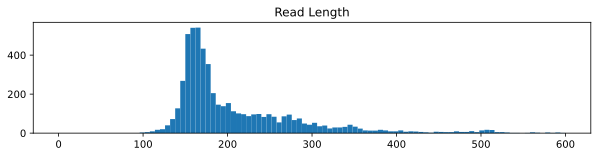

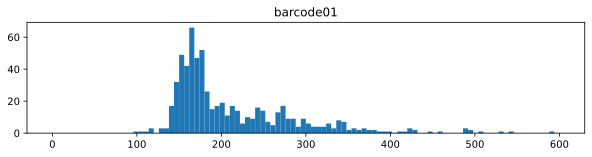

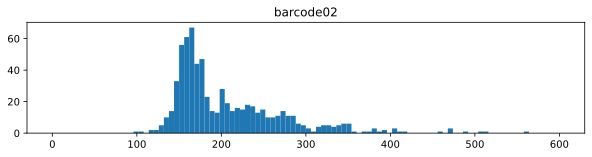

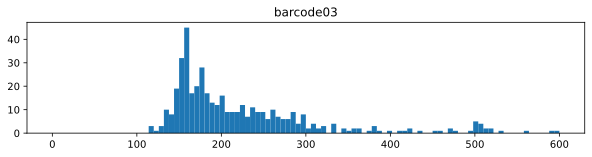

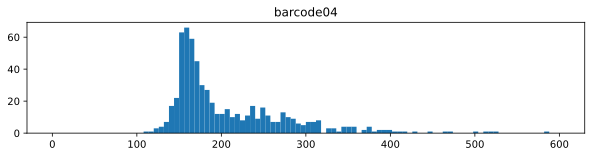

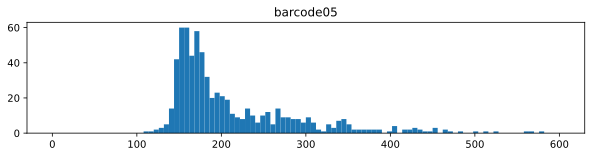

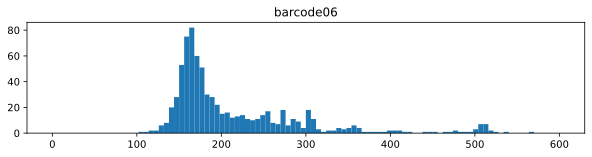

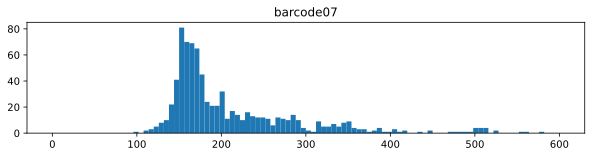

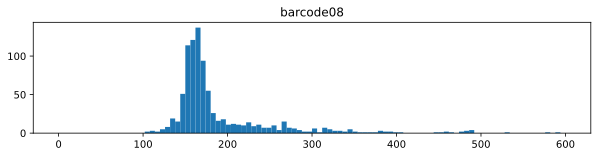

In [7]:
lengths=[]
for (subdir, read, hits) in getAllPrimerMatches():
    lengths.append(len(read.seq))
pd.DataFrame({'Read Length': lengths}).hist(bins=100, figsize=(10,2), grid=False, range=(0,600));

for subdir in getAllFastQDirs():
    lengths=[]
    for (read, hits) in getPrimerMatches(subdir):
        lengths.append(len(read.seq))
    pd.DataFrame({subdir: lengths}).hist(bins=100, figsize=(10,2), grid=False, log=False, range=(0,600));    

Reads are relatively evenly distributed by barcode. Most reads are short, possibly primer-dimers flanked by barcode regions. There's a random smattering of longer reads. Barcode03, 06 and 07 have small but significant bumps around 500. Barcode08 has a notably higher concetration of short reads with a small blip at 500. This all matches the gel extremely well.

<br><img src="RC1-gel.jpg" width=500>

## What's the distribution of primer positions?

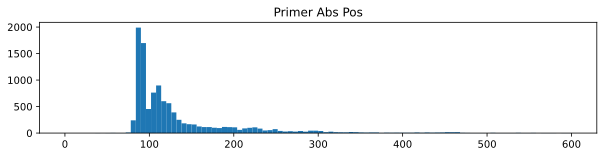

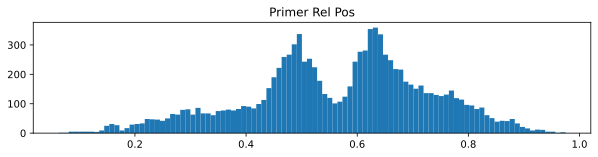

In [8]:
paPos=[]
prPos=[]

for (subdir, read, hits) in getAllPrimerMatches():
    paPos += map(lambda hit: hit.end, hits)
    prPos += map(lambda hit: (hit.start+hit.end)/2/len(read.seq), hits)

pd.DataFrame({'Primer Abs Pos': paPos}).hist(bins=100, figsize=(10,2), grid=False, range=(0,600))
pd.DataFrame({'Primer Rel Pos': prPos}).hist(bins=100, figsize=(10,2), grid=False);

The bimodal relative position may be because the most common pattern is a barcode prefix, primer, match region of arbitrary (but often low) length, primer and barcode suffix. 

## What is the distribution of read prefix and suffix lengths?
Suspect prefixes and suffixes before/after any primer hit is the barcode+adapter.

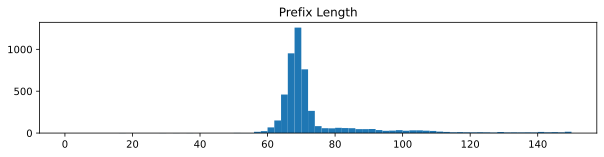

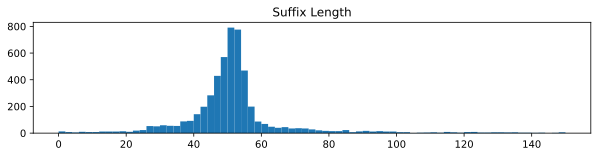

In [9]:
prefixLens=[]
suffixLens=[]

for (subdir, read, hits) in getAllPrimerMatches():
    if len(hits) >= 1:
        hits.sort(key=lambda h: h.start)
        prefixLens.append(hits[0].start)
        suffixLens.append(len(read.seq) - hits[-1].end)

pd.DataFrame({'Prefix Length': prefixLens}).hist(bins=75, figsize=(10,2), grid=False, range=(0,150))
pd.DataFrame({'Suffix Length': suffixLens}).hist(bins=75, figsize=(10,2), grid=False, range=(0,150));


Prefixes are almost always 60-75bp, suffixes are shorter 40bp-60bp. Both the prefix and the suffix have a long tail, perhaps due to missed primer hits or (for suffix) aborted reads. Prefixes are never shorter than 55bp, perhaps because then they would not have been identified as a matching barcode. These prefixes and suffixes almost certainly represent the barcodes and adapters attached to the start and end of the PCR product.

## Does the suffix length vary by barcode?
Perhaps the variance we see above is because of differing barcodes?

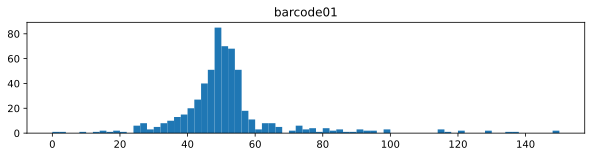

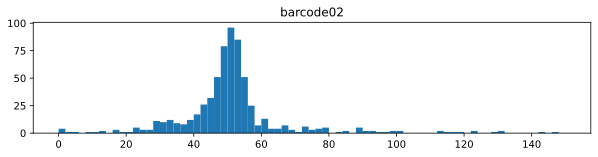

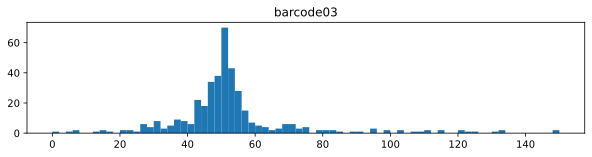

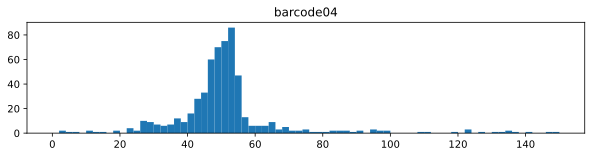

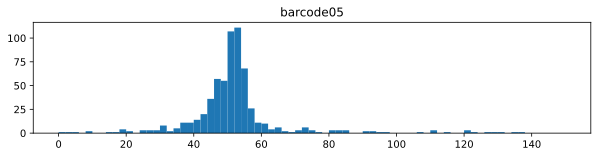

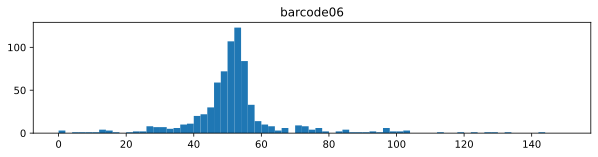

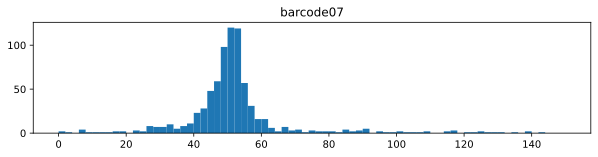

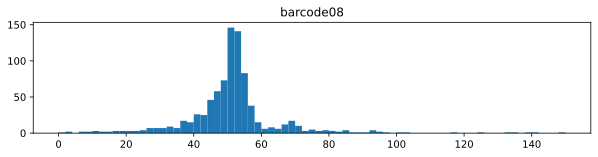

In [10]:
for subdir in getAllFastQDirs():
    suffixLens=[]
    for (read, hits) in getPrimerMatches(subdir):
        if len(hits) >= 1:
            lastHit = max(hits, key=lambda hit: hit.end)
            suffixLens.append(len(read.seq) - lastHit.end)
    pd.DataFrame({subdir: suffixLens}).hist(bins=75, figsize=(10,2), grid=False, range=(0,150));

There are some differences:
* barcode08 seems to have the most around the 70bp 2nd peak
* batcode01 seems to have the most less than 40bp

So the differences probably are related to barcode (or sample), but it's not clear.

## What is the distance between primer hits?
Can we tell the difference between primer-dimers and off-target amplification?

Human adenovirus 7
target          268 GGGGCTCAGGTACTCCGA 286
                  0 ||||||||||||||||||  18
query             0 GGGGCTCAGGTACTCCGA  18

Human coronavirus 229E 1
target          286 TAGAA-GGGCAAACGGGTGG 305
                  0 |||||-||||||||||||||  20
query             0 TAGAAAGGGCAAACGGGTGG  20

71% < 20bp
47% <= 0bp


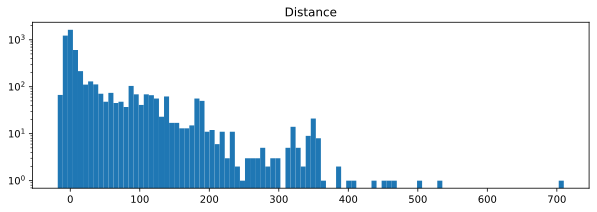

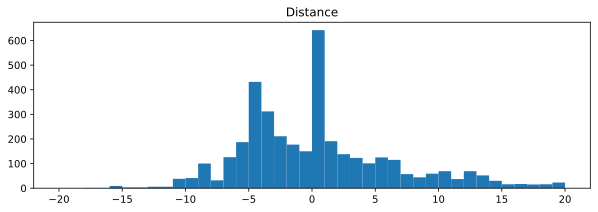

In [11]:
import matplotlib.pyplot as plt 

# Find the hits with the maximum overlap (below our threshold)
dists = []
countShort = 0
countAdjacent = 0
countTotal = 0
adjhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    hits.sort(key=lambda h: h.start)
    for i in range(len(hits)-1):
        countTotal += 1
        dist = hits[i+1].start - hits[i].end
        if dist < 20:
            countShort += 1
        if dist <= 0:
            countAdjacent += 1
        dists.append(dist)
        if dist == 0 and adjhit == None:
            adjhit = (read, hits[i], hits[i+1])

aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)
print(adjhit[1].primer.description)
print(aligner.align(adjhit[0].seq, adjhit[1].primer.rcSeq if adjhit[1].rev else adjhit[1].primer.seq)[0])
print(adjhit[2].primer.description)
print(aligner.align(adjhit[0].seq, adjhit[2].primer.rcSeq if adjhit[2].rev else adjhit[2].primer.seq)[0])

print("%d%% < 20bp" % int(100*countShort/countTotal))
print("%d%% <= 0bp" % int(100*countAdjacent/countTotal))

df = pd.DataFrame({'Distance': dists})
df.hist(bins=100, grid=False, log=True, figsize=(10,3))
df.hist(bins=40, grid=False, range=(-20,20), figsize=(10,3));

When there is more than one primer hit in a read, most of the time (71%) they are separate by no more than 20bp, and most commonly (47%) they are immediately adjacent (primer-dimers).

## How much do primer hits overlap below our threshold?
Partial overlap of primer hits is an indication of primer-dimers, which we should expect to be more common at lower overlap ratios. High or total overlapping primer hits would come from primers targetting different variants of the same locus, but we filter out such overlaps early. Look for any evidence that we haven't filtered out enough.

Max overlap score: 0.78, read 35e315b6-3dc9-4f51-9974-0be98e9e45d5, len 159, suffix 44
Measles virus 2 mr=0.80
target           59 TCGACAGCACCTTCGACTGTC 80
                  0 ||..|.|-||||||||||||| 21
query             0 TCAGCTG-ACCTTCGACTGTC 20

Influenza B virus 5 mr=0.80
target           81 AAATTATTCAAGGCATGTAAAATGAAGAA 110
                  0 |||||||||||.|||.||||||..|.|||  29
query             0 AAATTATTCAATGCAAGTAAAACTAGGAA  29

Human coronavirus NL63 1 (rev) mr=0.96
target           92 GGCATGTAAAATGAAGAAGGAGG 115
                  0 ||||||||||||||||.||||||  23
query             0 GGCATGTAAAATGAAGGAGGAGG  23



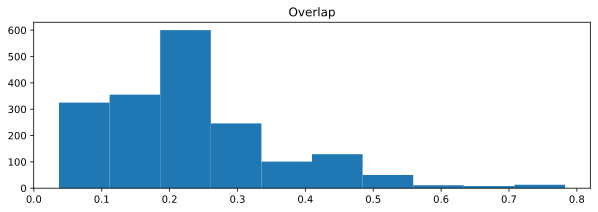

In [12]:
# Find the hits with the maximum overlap (below our threshold)
overlaps = []
maxo = 0
maxhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    for i in range(len(hits)):
        for j in range(i):
            o = RCUtils.computeOverlap(hits[i],hits[j])
            if o > 0:
                overlaps.append(o)
                if o > maxo:
                    maxo = o
                    maxhit = (read, hits)

maxoend = max([h.end for h in maxhit[1]])
print("Max overlap score: %.2f, read %s, len %d, suffix %d" % 
      (maxo, maxhit[0].id, len(maxhit[0].seq), len(maxhit[0].seq) - maxoend))
for hit in sorted(maxhit[1], key=lambda h: h.start):
    print("%s%s mr=%.2f" % (hit.primer.description, " (rev)" if hit.rev else "", hit.mr))
    print(aligner.align(maxhit[0].seq, hit.primer.rcSeq if hit.rev else hit.primer.seq)[0])
      
pd.DataFrame({'Overlap': overlaps}).hist(figsize=(10,3), grid=False);

As expected, most overlap is by a small amount - just a few bases.
Looking at the read with the maximum overlap just below our 80% cutoff, it appears to be a straight-forward tripple primer-dimer. The prefix and suffix lengths are typical so this read is likely nothing more than these three primers and the barcode/adapters. The prefix is about 10bp shorter than the median, but these first 10 bp are a poor match to the primer. Perhaps the primer was truncated during adapter attachment?

# Find possible primer pairs

In [13]:
def getPrimerPairs(subdir=None):
    if subdir:
        gen = ((subdir, read, hits) for (read, hits) in getPrimerMatches(subdir))
    else:
        gen = getAllPrimerMatches()
    for (subdir, read, hits) in gen:
        for hit1 in hits:
            if not hit1.rev:
                desc = hit1.primer.description[:hit1.primer.description.rindex(' ')]
                for hit2 in hits:
                    if hit2.rev and hit1.primer.baseName == hit2.primer.baseName \
                            and hit1.primer.description != hit2.primer.description:
                        span = hit2.start - hit1.end - 1 if hit2.start > hit1.start else hit1.start - hit2.end - 1
                        (p1,p2) = (hit1.primer.description, hit2.primer.description)
                        if len(p1) > len(p2) or (len(p1) == len(p2) and p1 > p2):
                            (p1,p2) = (p2,p1)
                        pairname = p1 + "/" + p2[p2.rindex(" ")+1:]
                        yield (subdir, read, hit1, hit2, span, pairname)

## What's the distribution of spans between possible primer pairs

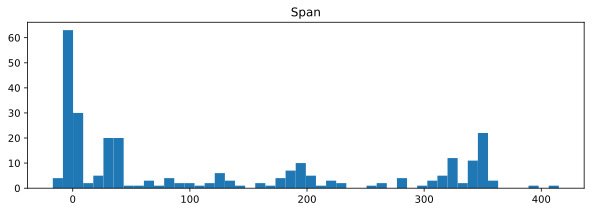

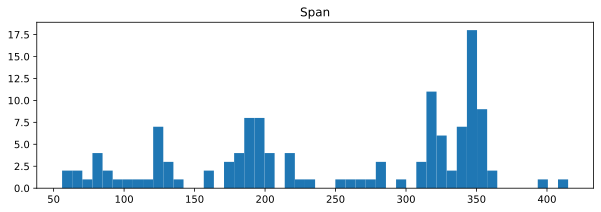

In [14]:
spans = []
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs():
    spans.append(span)

df = pd.DataFrame({'Span': spans})
df.hist(bins=50, grid=False, figsize=(10,3));
df[df["Span"]>50].hist(bins=50, grid=False, figsize=(10,3));

There's some obvious clusters which represent real matches (eg. around 350 and 320) as well as a smattering of others.

## Find the primer pairs that occur most often per subdir and analyze their spans
For any given primer pair we expect the (distance in the read from start of first primer to end of second) to be consistent from read to read in true matches, but possibly more variable for mispriming.  

In [15]:
from collections import defaultdict
import statistics

perSubdirPrimer = defaultdict(lambda:{"count":0, "spans":[], "mrs":[], "readIds":[]})
totalPairs = 0
likelyPairs = 0
goodPairs = 0

for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs():
    totalPairs += 1
    if (span > 50):
        row = perSubdirPrimer[(subdir, pairname)]
        row["spans"].append(span)
        row["mrs"].append(hit1.mr)
        row["mrs"].append(hit2.mr)
        row["readIds"].append(read.id)

known_good_subdir_pairs = set()
known_good_reads = set()
table = {"Subdir":[], "PrimerPair":[], "Count":[], "SpanMedian":[], "SpanSD":[], "MRMedian":[]}
for ((subdir, primerpair),row) in perSubdirPrimer.items():
    count = len(row["spans"])
    if count > 1:
        likelyPairs += count
        table["Subdir"].append(subdir)
        table["PrimerPair"].append(primerpair)
        table["Count"].append(count)
        spans = row["spans"]
        table["SpanMedian"].append(round(statistics.median(spans)))
        table["SpanSD"].append(round(statistics.pstdev(spans)))
        table["MRMedian"].append(round(statistics.median(row["mrs"]), ndigits=2))
    if count > 3:
        goodPairs += count
        known_good_subdir_pairs.add((subdir, primerpair))
        known_good_reads |= set(row["readIds"])

print("Showing %d of %d possible pairs (%d%%), with %d known good" % 
      (likelyPairs, totalPairs, int(100*likelyPairs/totalPairs), goodPairs))
df = pd.DataFrame(data=table)
df.set_index(["Subdir","PrimerPair"], inplace=True)
df.sort_values("Count", ascending=False, inplace=True)
df

Showing 75 of 274 possible pairs (27%), with 57 known good


Count  SpanMedian  SpanSD  MRMedian
Subdir    PrimerPair                                                     
barcode08 SARS coronavirus 1/2 5/6       14         320       4      0.97
barcode03 Rhinovirus/Enterovirus 1/3     11         344      12      0.97
barcode07 Rhinovirus/Enterovirus 1/3     11         350       6      0.90
barcode06 Rhinovirus/Enterovirus 1/3      9         347       4      0.90
          Rhinovirus/Enterovirus 2/3      8         345       9      0.90
barcode08 SARS coronavirus 1/2 3/4        4         220       7      0.97
barcode01 Human adenovirus 8/13           3         186       3      1.00
barcode03 SARS coronavirus 1/2 2/6        3         133      20      1.00
          Influenza A virus 2/13          2         126       0      0.95
barcode05 Human adenovirus 8/13           2         178       6      0.91
          Human adenovirus 8/9            2         257      64      0.89
barcode06 Human adenovirus 6/9            2         192       2      1.00
          Influenza A virus 2/13          2         201       0      0.89
          Influenza A virus 2/7           2         280       2      1.00

Here we see the true hits (already known from independent sequence alignment): 
 * barcode 8: SARS-CoV-2  (~320bp and ~220bp peaks above)
 * barocde 3, 6 and 7: Rhinovirus (~350bp peak above, expected ~353)
 
Note that the spans for likely matches have a low standard deviation.

## Do known good reads ever have more than 2 primer hits?

In [16]:
from collections import defaultdict
hitCounts = defaultdict(int)
for (subdir, read, hits) in getAllPrimerMatches():
    if (read.id in known_good_reads):
        if len(hits) > 2:
            hits.sort(key=lambda h: h.start)
            print("%s read %s (len %d)" % (subdir, read.id, len(read.seq)))
            for hit in hits:
                print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))

barcode03 read ced0bdea-73ef-440d-9440-a13702a18140 (len 916)
   1.00 63-84: Rhinovirus/Enterovirus 1 (21)
   1.00 394-415: Rhinovirus/Enterovirus 3 (21 rev)
   0.82 421-438: Human adenovirus 8 (17)
   0.94 631-650: Human adenovirus 9 (18 rev)
   0.95 650-671: SARS coronavirus 1/2 1 (20)
   1.00 843-864: Human parechovirus 2 (21 rev)
barcode06 read 8dc535d7-7df9-41f7-8302-84d9d4b5fd07 (len 735)
   0.88 66-93: Mycoplasma pneumoniae 2 (24)
   0.95 298-320: Rhinovirus/Enterovirus 3 (21)
   0.86 667-687: Rhinovirus/Enterovirus 1 (21 rev)
barcode06 read 9a780d7b-4502-4f17-a642-f7d0140445d7 (len 648)
   0.81 71-91: Rhinovirus/Enterovirus 3 (21)
   0.90 423-443: Rhinovirus/Enterovirus 2 (21 rev)
   1.00 575-596: Human parechovirus 2 (21 rev)
barcode07 read 6082e1b1-de83-41be-8e44-a5834f145c04 (len 902)
   1.00 68-89: Rhinovirus/Enterovirus 1 (21)
   1.00 439-460: Rhinovirus/Enterovirus 3 (21 rev)
   1.00 460-480: Herpes simplex virus 2 (20)
   0.83 829-851: Streptococcus pneumoniae 2 (24 rev)

It's apparently quite common to have concatenated reads combining good target hits with off-target hits. It's also apparently common to have some primer-dimers attached to the primers from good reads.

## Are the AdV matches in barcode01 real?

In [17]:
def hitString(hit):
    return "%s%s [%d,%d] (%.2f)" % (hit.primer.description, " (rev)" if hit.rev else "", hit.start, hit.end, hit.mr)

for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs("barcode01"):
    if (pairname=="Human adenovirus 8/13"):
        print(">" + hitString(hit1) + " - " + hitString(hit2))
        print("  " + read.seq[hit1.start:hit2.end])

>Human adenovirus 8 [67,83] (0.88) - Human adenovirus 13 (rev) [265,281] (0.82)
  GCAGTGCGGAGTAGGGAAAGGGAAAGCAGAGCGTGGGACTGTCCCTCTGTGCTGGAAGAGGGCTAACACAGCCCCGACTCTCCGCTCTGGCTGAGCCGAGGGGCCTCTCGCCTCCCTCTGTGTTGCCCTAGGGCTCGGTGACCTCTGTCATAGCACTGACCACATGCTATCCTGCCTGTGCCTTCTCTAGCTGTCCCGCCCTGCTCGGAACCGC
>Human adenovirus 13 [193,210] (1.00) - Human adenovirus 8 (rev) [397,414] (1.00)
  GCGGTTCCGGAGTAGGGCGGGGGACAGCTAGAGGAAGGCACAGGCAGGATACCATGTGGTCAGTGCTATGACAGGGTCACCGAGCCCTAGGGCAGCACAGAGGGACAGGGCCCCCTTGGCCTAGCCAGGTGGAGAGTCCGGGCTGGTGTTATGGCCCTCTTCCAGCACAGAGGGAGAGTCCACCCTCTGCTTCTCTTCCCTTTCCCCTACTCCGGCACTGC
>Human adenovirus 13 [64,81] (1.00) - Human adenovirus 8 (rev) [270,287] (1.00)
  GCGGTTCCGGAGTAGGGCAGGGGACAGCTAGAGGAAGGCACAGGCAGGATAGCATGTGGTCCAGTGCTATGACAGAGGTCACCGAGCCCTAGGGCAACACAGAGGACAGAGGGCCCCCTTGGCCTAGCCAGGTGGAGATCCGGGCTGGTGTTAGCCCTCTTCCAGCCACAGAGGGAGAGTCCCACCCTCTGCTTCTCTTCCCTTTCCCCTACTCCGGCACTGC


**No**. [Doing a BLAST](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastSearch&VIEW_SEARCH=on&UNIQ_SEARCH_NAME=A_SearchOptions_1pOl9S_kyl_dsIGlk8G2B7_GTWlT_NCQp) for this output shows a near perfect match (~one mismatch per primer) to Human Chromosome X. Also the two primers both map to the same position on the minus strand of the Adenovirus genome, so they're not a legit pair. We could exclude these by capturing expected pairings (or at least strand) in the primer input.

## Why are the Rhinovirus reads in barcode06 split?
They're evenly split between the Rhinovirus primer (#1) and Enterovirus D68 primer (#2). Is it possible we have some D68 reads?

In [18]:
printed = 0
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs("barcode06"):
    if (pairname=="Rhinovirus/Enterovirus 2/3"):
        print(">" + hitString(hit1) + " - " + hitString(hit2) + " len=" + str(len(read)))
        print("  " + read.seq[hit1.end:hit2.start])  # trim primers
        printed += 1
        if printed == 3:
            break

>Rhinovirus/Enterovirus 3 [64,85] (1.00) - Rhinovirus/Enterovirus 2 (rev) [433,452] (0.81) len=478
  TGGTCCCATCCCGCAGTTGCCCGTTACGACTAGCTACACACTGGTTTGCGTGCACTAGCTGCAGGTTTAAGGTTAGCCACATTCAGGGGCCGGAGGACTCAATGCGAGCACGAAGGCTCTTCGCACCTTGTCAAATATACGGCTTCGCACTCAAAGAGTGCGCAGGCAGCCCGCAGGCTAGAACACTGTCGCCAGTGGGGAGCTTCCTAGCCTCATCTGCCAGGTCTACCATGGGAATGGCGGAGCAGCCAACCACATATCATTTCAAGATGATACTAGGCTTTGCGTAGGCACATTGCGGATAACGATCTCAATTGTTTTTGCCCTGGGAGAGCATATCAACTTTGA
>Rhinovirus/Enterovirus 3 [64,85] (1.00) - Rhinovirus/Enterovirus 2 (rev) [411,428] (0.81) len=471
  TGGTCCCATCCCACTGGTGCCGTTACATTCTTCTTTTGGTTTGCATGCACTAGCTGCAGGTTGGGTTAGCCGATTTCAGGGGCCGGAGGACTCAATGTGAGCACGGAATCTTCACCGTAAACCTGCAGCTACTTGCTCAAAGGTGTGAGCCTTTCCTGGCTAGAACACTGTCTCAGCGGTGGGGCTTCTAGCCTCATCTGCCAAGTCCTGTGGGGAATGGCGGAACGACCAACCACATATCATTCCAAGATGATACTAAACTGCGTAGGCACATTGCGGATAACGATCTCAATTTTTTGCCCTGGGAAACATATCAACTTTGATAA
>Rhinovirus/Enterovirus 3 [67,88] (1.00) - Rhinovirus/Enterovirus 2 (rev) [430,450] (0.90) len=504
  TTGGTCCCATCCCGCAGTTGC

A blast search returns Rhinovirus A56, so this is a simple case of mis-priming. It's surprising that the matching primer and mismatching primer are represented at equal frequency.

## What's the cause of the high span deviation in barcode03?

In [19]:
table = {"Read":[], "Len":[], "Span":[]}
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs("barcode03"):
    if (pairname=="Rhinovirus/Enterovirus 1/3"):
        table["Read"].append(read.id)
        table["Len"].append(len(read))
        table["Span"].append(span)

df = pd.DataFrame(data=table)
df.set_index("Read", inplace=True)
df.sort_values("Span", inplace=True)
df

,Len,Span
Read,,
ced0bdea-73ef-440d-9440-a13702a18140,916,309
ab450ac2-25a8-46c1-aba9-b3256eea9382,504,334
7eca4cf2-4752-47a8-9ce3-a55b7fb468c2,476,338
7f58b3b6-8002-4fa8-869a-3770f20f8b22,500,341
96f7eb6d-9aa6-4927-9d8a-d1aa1bba097d,503,342
5aec69e7-8ec7-4b39-b3f3-c0edcad3eace,504,344
3f464a18-cb4d-4f85-8baa-47f7cc1699b8,506,345
946bd1d5-9c37-4979-9965-1b5c75e3ca73,510,347
e560f5d3-d7d2-447a-bbb2-769053f360d7,533,350


It looks like one read is a real outlier and others are shorter. Let's visualize this with an alignment.

In [20]:
match1 = None
match2 = None
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs("barcode03"):
    if pairname=="Rhinovirus/Enterovirus 1/3":
        if span==345:
            match1 = read[hit1.end:hit2.start]
        if span==309:
            match2 = read[hit1.end:hit2.start]
print(aligner.align(match1.seq, match2.seq)[0])

target           16 CCACCAGGGCAAAAACAGCTGCGATCGTTATCCGCAAAGCGCCTACGCAAAGCTTAGTAG
                  0 ||...-||||||||||||||||||||||||||||||||.||||||||||||||||.||||
query             1 CCGTG-GGGCAAAAACAGCTGCGATCGTTATCCGCAAAACGCCTACGCAAAGCTTGGTAG

target           76 TACTCTGGAAGTTGTCTGGCTGGTCGCTCCACCATTCCCCTGGTAAGGCCACG--GATGA
                 60 |.|||||-|-||||||-||||||||.-||..---|.||--|||||-|.||..|--|||||
query            60 TGCTCTG-A-GTTGTC-GGCTGGTCA-TCTG---TGCC--TGGTA-GACCTGGCAGATGA

target          134 GGCCT-AAGCTCCCCACTGGCGACAGTGTTCTAGCCTGCGTGGCTGCCTGCACACCCTCT
                120 |||..-||.||||||||||||||||||||||.||||||--|||||||||-|------|--
query           110 GGCTAGAAACTCCCCACTGGCGACAGTGTTCCAGCCTG--TGGCTGCCT-C------T--

target          193 GGGTGTGAAGCCATACAATGGAC----AGGTGTGAAGAGCCCCCGTGTGCTCGCTTT-GA
                180 |||||||||||||||||||||||----||||||||||||||||-|||||||||||||-||
query           159 GGGTGTGAAGCCATACAATGGACTGTGAGGTGTGAAGAGCCCC-GTGTGCTCGCTTTTGA

target          248 GTCC

There's just a number of deletions in the read with a shorter span. 

## Is there any pattern to the sequence data at the start and end of a good read?
Let's start by looking at the distribution of the lengths

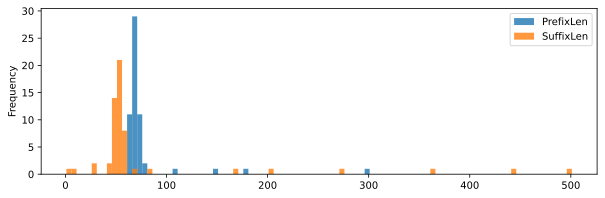

In [21]:
prefixes = []
suffixes = []
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs():
    if (subdir, pairname) in known_good_subdir_pairs:
        prefixes.append(read.seq[:hit1.start])
        suffixes.append(read.seq[hit2.end:])

df = pd.DataFrame({'PrefixLen': map(lambda seq: len(seq), prefixes),
                   'SuffixLen': map(lambda seq: len(seq), suffixes)})
df.plot.hist(alpha=0.8, bins=100, grid=False, figsize=(10,3));

As for all reads, the prefixes and sufxies tend to be pretty specific lengths, but also have some outliers. See if there is any specific sequence that is most common in each.

In [22]:
prefixCount = Counter()
suffixCount = Counter()

for prefix in prefixes:
    prefixCount[str(prefix)] += 1
for suffix in suffixes:
    suffixCount[str(suffix)] += 1

print ("Repeat prefixes: " + str({k:v for (k,v) in prefixCount.items() if v >1}))
print ("Repeat suffixes: " + str({k:v for (k,v) in suffixCount.items() if v >1}))

Repeat prefixes: {}
Repeat suffixes: {'AGGTGCTGGTGTTACCGTGGGAATGAATCCTTTTAACCTTAGCAATACGTAAC': 2}


Just one duplicate sequence. A [BLAST search](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastSearch&VIEW_SEARCH=on&UNIQ_SEARCH_NAME=A_SearchOptions_1pTqx4_bv_dv13RPAu13qg_23tp8J_c1hZ1) shows 4 perfect reverse-complement matches for the first 32 baes. The hits are to 4 different SARS-CoV-2 MinION sequences from the same institution. Looking at [an alignment](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastSearch&VIEW_SEARCH=on&UNIQ_SEARCH_NAME=A_SearchOptions_1pTr3b_oEn_dvtIuDR22hk_GTW6B_J9IZt) of one of those to the SARS-CoV-2 reference sequence, it's clear the first 33 bases don't really match. This seems consistent with a barcode sequence that wasn't properly trimmed from the sequence.

Let's generate a FASTA file for two of the barcodes for a multiple sequence alignment.

In [23]:
i = 0
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs():
    if (subdir, pairname) in known_good_subdir_pairs:
        prefix = read.seq[:hit1.start]
        if len(prefix) < 100:
            print (">" + subdir + "p" + str(i))
            print (prefix)
        suffix = read.seq[hit2.end:]
        if len(suffix) < 100:
            print (">" + subdir + "s" + str(i))
            print (suffix)
        i += 1


>barcode03p0
GCACTCGGTGCTTCGTTCGATTACACGTATTGCTAGGTTAACCTGGTAACTGGGATACAGACTCCAGCACCT
>barcode03s0
AGGTGTGGTGCTTGTCCCAGTTACCAGGTTAACAGCAATACGTAG
>barcode03p1
CAGTGGTGCTTCGTTCAGTTACGTATTTTCTGGCCTGGTAACTGCAGGACTGGGCTAGCACCT
>barcode03p2
GCATGCTTCGTTCAGTTACACGTATTGCTAAGGTTAACCTGGTAACTGGGACACAAGACTTCCAGCACCT
>barcode03s2
GGGTGCTGGAGTCTTGTGTCCCAGTTACCAGGTTAACCTTAGCGTAA
>barcode03p3
TCAGTACTTCGTTCAGTTACGTATTGCTAAGGTTAACCTGGTAACTGGGACACAAGACTCCAGCACCT
>barcode03s3
GAGTGCTGAGTCTTGTGTCCCAGTTACCAGGTTAGCATAGCAATACGTAAC
>barcode03p4
CACATGTACTTCCGTTCAGTTACGTATTGCTAAGGTTAACCTGGTAACTGGGACACAAGACTCCAGCACT
>barcode03s4
GTGCAGGTCTTGTGTCCCAGTTACCAGGTTAACCTTAGCAATACGTGAGAAAGCTTC
>barcode03p5
GGTATGCTTCGTTCAGTTACGTATTGCTAAGGTTAACCTGGTAACTGGGACACAAGACTCCAGCACCT
>barcode03s5
CGAGGGTGCAGGTCTTGTGTCCCAGTTACCAGGTTAACCTTAGCAATACGTAG
>barcode03p6
CGGTATTGCTTCGTTCCAGTTACGTATTGCTAAGGTTAACCTGGTAACTGGAAGCTAGGAACTCCAGCACCT
>barcode03s6
AGGTGCTGGAGTCTTGTGTCAGTTACCAAGGTTAACTATAGCAATACAT
>barcode03p7
CAGTATGCTTCGTTCCAGTT

Loading the above into [Clustal Omega](https://www.ebi.ac.uk/Tools/msa/clustalo/) it's [clear](https://www.ebi.ac.uk/Tools/services/web/toolresult.ebi?jobId=clustalo-I20230211-224533-0470-67694562-p1m) they group by barcode, with all the prefixes being similar and all the suffixes being similar. Therefore these are likely include the barcode patterns.

# Debugging

In [24]:
# Dump all the matches for specific known reads for debugging purposes
RCUtils.primer_hits_to_print = 50
for read in getAllReads():
    interestingReads = [
        "c63d9144-0d93-4620-ba79-2a7bf050e813",  # rhinovirus match
        "6129522a-5587-4009-ad7d-e76d677283ab",  # rhinovirus reverse match
        "35e315b6-3dc9-4f51-9974-0be98e9e45d5",  # max overlap
        "b9052c5f-4355-4895-97c8-5297c57cc1c7",  # 7 hits
        "825687be-49e0-4c4b-a950-609181d23d78",  # longest read (1400bp) but with only one hit
    ]
    if read.id in interestingReads:
        print("Read %s len %i" % (read.id,len(read.seq)))
        hits = RCUtils.computePrimerHits(read, primers)
        if len(hits)>0:
            print("Match summary:")
            for hit in hits:
                print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))
                print("    " + read.seq[hit.start:hit.end])
                print("    " + read.seq[hit.start:hit.end].reverse_complement())
            print("")

Read b9052c5f-4355-4895-97c8-5297c57cc1c7 len 288
Match: 0.80 Hendra virus 5 (rev)
target          173 AGCTGCAAAATTTGGCTT 191
                  0 |||||||||-||||||||  18
query             3 AGCTGCAAA-TTTGGCTT  20

Match: 0.86 Human adenovirus 6
target           92 TTGTAAGCAGTGCCAGAGT 111
                  0 |||||||||||||||||||  19
query             0 TTGTAAGCAGTGCCAGAGT  19

Match: 0.96 Human coronavirus 229E 2 (rev)
target          208 GCGGCTCTTAAATCTTTAGGTTTT 232
                  0 ||||||||||||||||||||||||  24
query             0 GCGGCTCTTAAATCTTTAGGTTTT  24

Match: 0.95 Influenza A virus 1
target          124 CTGGTGCACTTGCCAGCTG 143
                  0 ||||||||||||||||.||  19
query             0 CTGGTGCACTTGCCAGTTG  19

Match: 1.00 Influenza A virus 2
target          124 CTGGTGCACTTGCCAGCTG 143
                  0 |||||||||||||||||||  19
query             0 CTGGTGCACTTGCCAGCTG  19

Match: 1.00 Nipah virus 2 (rev)
target          104 CCAGAGTGACCTCAACACCA 124
                  0 |||||

## Dump details of long barcode01 reads
They look suspiciously legit, but apparently are just off-target and primer concatemers. 

In [25]:
longReads = []
for (read, hits) in getPrimerMatches("barcode01"):
    if len(read.seq) > 450:
        longReads.append((read, hits))

longReads.sort(key=lambda p: len(p[0].seq))
for (read, hits) in longReads:
    print ("read %s len=%d: " % (read.id, len(read.seq)))
    hits.sort(key=lambda h: h.start)
    for h in hits:
        print ("  %s%s @%d-%d" % (h.primer.description, "(rev) " if h.rev else "", h.start, h.end))

read 975d4bf5-e5af-49f5-b98c-97ef56c05591 len=461: 
  Human coronavirus 229E 1(rev)  @172-192
  Human adenovirus 13 @193-210
  Human adenovirus 8(rev)  @397-414
read 39986368-26c8-4da1-82e1-dc109c02ff36 len=486: 
  Herpes simplex virus 2 @69-89
  Human coronavirus OC43 1(rev)  @412-434
read 0dd60860-c3e4-4138-bc86-306b61dd8e3a len=489: 
  Herpes simplex virus 2 @74-94
  Rhinovirus/Enterovirus 2(rev)  @318-338
  Influenza B virus 4 @338-364
  Hantaan virus 3(rev)  @417-440
read d3feaa8d-9b91-4fe3-894d-3722b70aa4ef len=490: 
  Influenza A virus 12 @140-164
read f15e65ad-2c9e-4840-8cc0-cdce483e38fd len=492: 
  Mycoplasma pneumoniae 2 @67-90
  Human adenovirus 7(rev)  @268-286
  Human coronavirus 229E 1 @286-305
  Influenza A virus 2(rev)  @445-464
read 954e6083-443d-442c-92f5-4cb4bd3d0bd8 len=492: 
  Human cytomegalovirus 2 @72-93
  Human bocavirus 2(rev)  @424-444
read d46de6d2-b002-47e3-9c16-9eb7280763f2 len=504: 
  SARS coronavirus 1/2 3 @70-90
  Nipah virus 2 @259-280
  Human metapneu

# Summary
From everything we've computed above, generate summary stats for each subdir.

In [26]:
statsPerSubdir = defaultdict(lambda: defaultdict(int))
for (subdir, read, hits) in getAllPrimerMatches():
    stats = statsPerSubdir[subdir]
    stats["reads"] += 1
    stats["bases"] += len(read.seq)
    if len(hits) > 0:
        stats["withHits"] += 1

        # Calculate total bases covered by all hits
        hitBases = 0
        for hit in hits:
            hitBases += hit.end - hit.start

        if len(hits) > 1:
            stats["withMultipleHits"] += 1
            hits.sort(key=lambda h: h.start)
            # Compute max distance between end of one hit and start of next
            maxSpan = 0
            for i in range(len(hits)-1):
                span = hits[i+1].start - hits[i].end
                if span < 0:
                    hitBases += span # Subtract overlap to avoid double-counting
                else:
                    stats["spanBases"] += span
                maxSpan = max(maxSpan, span)
            if maxSpan > 0:
                stats["withSpan"] += 1
                if maxSpan > 50:
                    stats["withSpanOver50"] += 1
        stats["hitBases"] += hitBases

    stats["knownGood"] += 1 if read.id in known_good_reads else 0

relStatsPerSubdir = defaultdict(dict)
for (subdir, stats) in statsPerSubdir.items():
    rs = relStatsPerSubdir[subdir]
    rs["reads"] = stats["reads"]
    rs["no hits"] = (stats["reads"] - stats["withHits"]) / stats["reads"]
    rs["lone hit"] = (stats["withHits"] - stats["withMultipleHits"]) / stats["reads"]
    rs["only dimers"] = (stats["withMultipleHits"] - stats["withSpan"]) / stats["reads"]
    rs["short span"] = (stats["withSpan"] - stats["withSpanOver50"]) / stats["reads"]
    rs["off target"] = (stats["withSpanOver50"] - stats["knownGood"]) / stats["reads"]
    rs["good"] = stats["knownGood"] / stats["reads"]
    rs["primer bases"] = stats["hitBases"] / stats["bases"]
    rs["span bases"] = stats["spanBases"] / stats["bases"]
pd.options.display.float_format = '{:.1%}'.format
pd.DataFrame.from_dict(relStatsPerSubdir, orient='index')

,reads,no hits,lone hit,only dimers,short span,off target,good,primer bases,span bases
barcode01,647,4.0%,24.6%,25.3%,25.7%,20.4%,0.0%,17.9%,17.0%
barcode02,692,5.3%,21.4%,26.2%,29.5%,17.6%,0.0%,18.4%,12.8%
barcode03,436,4.4%,24.3%,23.9%,24.8%,20.2%,2.5%,16.9%,18.3%
barcode04,624,4.3%,20.5%,27.7%,29.5%,17.9%,0.0%,18.8%,13.6%
barcode05,682,4.7%,24.2%,29.2%,24.5%,17.4%,0.0%,16.9%,13.7%
barcode06,771,3.4%,24.3%,24.9%,26.6%,18.7%,2.2%,17.8%,16.5%
barcode07,809,2.8%,25.5%,23.7%,29.3%,17.3%,1.4%,18.2%,14.8%
barcode08,894,2.7%,22.0%,35.9%,29.8%,7.6%,2.0%,20.1%,9.3%
